# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import nltk
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger'])
from sqlalchemy import create_engine
import re
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV

import pickle
import warnings
import time

import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sgkey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sgkey\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sgkey\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# load data from database
engine = create_engine('sqlite:///DisasterResponse.db')
df = pd.read_sql_table('1st',engine)

In [54]:
df.head(5)

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df.shape

(26216, 40)

In [4]:
df.isna().sum()

id                            0
message                       0
original                  16046
genre                         0
related                       0
request                       0
offer                         0
aid_related                   0
medical_help                  0
medical_products              0
search_and_rescue             0
security                      0
military                      0
child_alone                   0
water                         0
food                          0
shelter                       0
clothing                      0
money                         0
missing_people                0
refugees                      0
death                         0
other_aid                     0
infrastructure_related        0
transport                     0
buildings                     0
electricity                   0
tools                         0
hospitals                     0
shops                         0
aid_centers                   0
other_in

In [5]:
df.iloc[:,4:].sum()

related                   20282
request                    4474
offer                       118
aid_related               10860
medical_help               2084
medical_products           1313
search_and_rescue           724
security                    471
military                    860
child_alone                   0
water                      1672
food                       2923
shelter                    2314
clothing                    405
money                       604
missing_people              298
refugees                    875
death                      1194
other_aid                  3446
infrastructure_related     1705
transport                  1201
buildings                  1333
electricity                 532
tools                       159
hospitals                   283
shops                       120
aid_centers                 309
other_infrastructure       1151
weather_related            7297
floods                     2155
storm                      2443
fire    

The category "child_alone" only has 1 class. I decide to remove this column because it is not informative for machine learning.

In [6]:
df = df.drop("child_alone",axis = 1)

In [7]:
X = df.message.values
Y = df.drop(["message","id","original","genre"],axis = 1).values

This dataframe below is to see how many tokens in each categories by genre.

In [8]:
df_genre_scatter = df.groupby("genre").sum().drop(["id"],axis = 1)
df_genre_scatter

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
genre,,,,,,,,,,,,,,,,,,,,,
direct,7446,3696,46,4338,592,471,216,131,46,836,...,78,186,1521,304,315,41,796,63,207,3613
news,10707,604,65,5860,1415,793,441,292,801,790,...,218,866,4280,1747,1445,225,910,415,1052,852
social,2129,174,7,662,77,49,67,48,13,46,...,13,99,1496,104,683,16,749,52,117,610


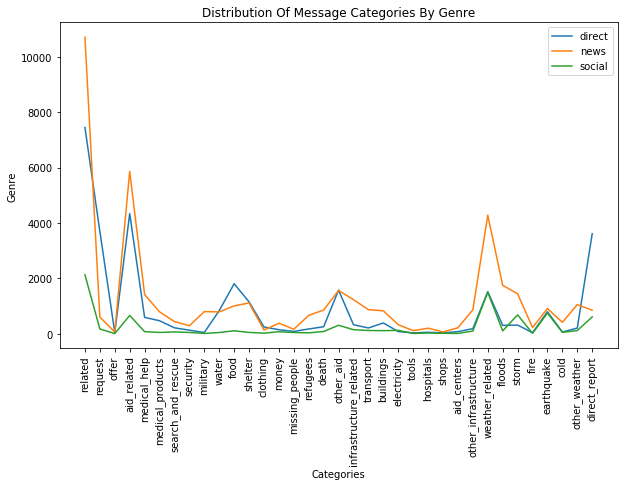

In [9]:

plt.figure(figsize=(10, 6))
plt.title('Distribution Of Message Categories By Genre')
plt.plot(df_genre_scatter.T)
plt.legend(df_genre_scatter.index.values)
plt.xlabel("Categories");
plt.ylabel("Genre");
plt.xticks(rotation=90);

We can see the category:"related" has obviously big number,the genre:"news" has biger number than other two genres.

This dataframe below is to see histogram of token numbers in a given message.

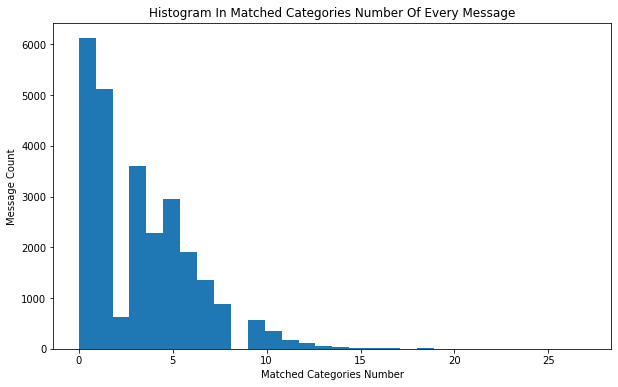

In [10]:
df_cate_hist = df.drop(["message","id","original","genre"],axis = 1)
df_cate_hist["count_cate"] = df_cate_hist.sum(axis = 1)
df_cate_hist["count_cate"].plot(kind = 'hist',bins = 30,figsize =(10,6),title = 'Histogram In Matched Categories Number Of Every Message')
plt.xlabel('Matched Categories Number');
plt.ylabel('Message Count');

This is left skewed distribution. Most of messages has less than 5 categories matched.

### 2. Write a tokenization function to process your text data

In [11]:
#lower case all tokens and strip spaces.
def tokenize(text):
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [12]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(MultinomialNB()))
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
# train classifier
pipeline.fit(X_train,Y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at 0x000002174A702B70>,
                                 vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultiOutputClassifier(estimator=MultinomialNB(alpha=1.0,
         

In [14]:
# predict on test data
Y_pred = pipeline.predict(X_test)

In [15]:
col_list = df.drop(["message","id","original","genre"],axis = 1).columns
col_list

Index(['related', 'request', 'offer', 'aid_related', 'medical_help',
       'medical_products', 'search_and_rescue', 'security', 'military',
       'water', 'food', 'shelter', 'clothing', 'money', 'missing_people',
       'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport',
       'buildings', 'electricity', 'tools', 'hospitals', 'shops',
       'aid_centers', 'other_infrastructure', 'weather_related', 'floods',
       'storm', 'fire', 'earthquake', 'cold', 'other_weather',
       'direct_report'],
      dtype='object')

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [16]:
#Print classification_report() result of each categories, and return a series inclueds f1-score of each categories.
def show_result(col_list,Y_test,Y_pred):
    f1score = []
    for i, col in enumerate(col_list):
        print(col + ":")
        d = classification_report(Y_test[i], Y_pred[i],output_dict = True)
        df = pd.DataFrame(d)
        print(df)
        f1score.append(d['weighted avg']["f1-score"])
    df_res = pd.Series(f1score,index = col_list)
    return df_res

result_pipe1 = show_result(col_list,Y_test,Y_pred)

related:
                   0         1  accuracy  macro avg  weighted avg
f1-score    0.985075  0.666667  0.971429   0.825871      0.975977
precision   1.000000  0.500000  0.971429   0.750000      0.985714
recall      0.970588  1.000000  0.971429   0.985294      0.971429
support    34.000000  1.000000  0.971429  35.000000     35.000000
request:
                   0     1  accuracy  macro avg  weighted avg
f1-score    0.967742  0.75  0.942857   0.858871      0.936636
precision   0.937500  1.00  0.942857   0.968750      0.946429
recall      1.000000  0.60  0.942857   0.800000      0.942857
support    30.000000  5.00  0.942857  35.000000     35.000000
offer:
                   0    1  accuracy  macro avg  weighted avg
f1-score    0.985507  0.0  0.971429   0.492754      0.985507
precision   1.000000  0.0  0.971429   0.500000      1.000000
recall      0.971429  0.0  0.971429   0.485714      0.971429
support    35.000000  0.0  0.971429  35.000000     35.000000
aid_related:
                 

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



other_infrastructure:
              0    1  accuracy  macro avg  weighted avg
f1-score    1.0  1.0       1.0        1.0           1.0
precision   1.0  1.0       1.0        1.0           1.0
recall      1.0  1.0       1.0        1.0           1.0
support    34.0  1.0       1.0       35.0          35.0
weather_related:
                   0    1  accuracy  macro avg  weighted avg
f1-score    0.985507  0.0  0.971429   0.492754      0.985507
precision   1.000000  0.0  0.971429   0.500000      1.000000
recall      0.971429  0.0  0.971429   0.485714      0.971429
support    35.000000  0.0  0.971429  35.000000     35.000000
floods:
                   0          1  accuracy  macro avg  weighted avg
f1-score    0.877193   0.461538       0.8   0.669366      0.758435
precision   0.781250   1.000000       0.8   0.890625      0.843750
recall      1.000000   0.300000       0.8   0.650000      0.800000
support    25.000000  10.000000       0.8  35.000000     35.000000
storm:
                   0    1

Check the series inclueds f1-score of each categories.

In [17]:
result_pipe1

related                   0.975977
request                   0.936636
offer                     0.985507
aid_related               0.968791
medical_help              0.975977
medical_products          0.711002
search_and_rescue         0.985507
security                  0.890549
military                  1.000000
water                     0.934226
food                      0.985507
shelter                   0.929437
clothing                  0.970588
money                     0.971429
missing_people            0.985507
refugees                  0.970075
death                     0.733698
other_aid                 0.897959
infrastructure_related    0.601905
transport                 0.985507
buildings                 0.929437
electricity               1.000000
tools                     0.929437
hospitals                 0.985507
shops                     0.772581
aid_centers               1.000000
other_infrastructure      1.000000
weather_related           0.985507
floods              

In [18]:
#Check parameters of pipeline for grid search.
pipeline.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 1), preprocessor=None, stop_words=None,
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=<function tokenize at 0x000002174A702B70>,
                   vocabulary=None)),
  ('tfidf',
   TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
  ('clf',
   MultiOutputClassifier(estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                                 fit_prior=True),
                         n_jobs=None))],
 'verbose': False,
 'vect': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
  

### 6. Improve your model
Use grid search to find better parameters. 

In [19]:
parameters = {
        'vect__ngram_range': ((1, 1), (1, 2)),
        'vect__max_df': (0.5, 0.75, 1.0),
        'tfidf__use_idf': (True, False),
        'clf__estimator__alpha':(0.5, 1.0)
 }

cv = GridSearchCV(pipeline, param_grid=parameters)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [20]:
#Grid search, and the time of process.
start = time.time()
cv.fit(X_train, Y_train)
elapsed_time =  time.time() - start
print("elapsed_time:{}".format(elapsed_time))

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


elapsed_time:597.1230561733246


In [21]:
Y_pred = cv.predict(X_test)

In [22]:
print("Classification Report:\n")
result_pipe1 = show_result(col_list,Y_test,Y_pred)
print("\nBest Parameters:", cv.best_params_)


Classification Report:

related:
              0    1  accuracy  macro avg  weighted avg
f1-score    1.0  1.0       1.0        1.0           1.0
precision   1.0  1.0       1.0        1.0           1.0
recall      1.0  1.0       1.0        1.0           1.0
support    34.0  1.0       1.0       35.0          35.0
request:
                   0     1  accuracy  macro avg  weighted avg
f1-score    0.967742  0.75  0.942857   0.858871      0.936636
precision   0.937500  1.00  0.942857   0.968750      0.946429
recall      1.000000  0.60  0.942857   0.800000      0.942857
support    30.000000  5.00  0.942857  35.000000     35.000000
offer:
                   0    1  accuracy  macro avg  weighted avg
f1-score    0.985507  0.0  0.971429   0.492754      0.985507
precision   1.000000  0.0  0.971429   0.500000      1.000000
recall      0.971429  0.0  0.971429   0.485714      0.971429
support    35.000000  0.0  0.971429  35.000000     35.000000
aid_related:
                   0         1  accuracy  m

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                   0    1  accuracy  macro avg  weighted avg
f1-score    0.985507  0.0  0.971429   0.492754      0.985507
precision   1.000000  0.0  0.971429   0.500000      1.000000
recall      0.971429  0.0  0.971429   0.485714      0.971429
support    35.000000  0.0  0.971429  35.000000     35.000000
floods:
                   0          1  accuracy  macro avg  weighted avg
f1-score    0.862069   0.333333  0.771429   0.597701      0.711002
precision   0.757576   1.000000  0.771429   0.878788      0.826840
recall      1.000000   0.200000  0.771429   0.600000      0.771429
support    25.000000  10.000000  0.771429  35.000000     35.000000
storm:
                   0    1  accuracy  macro avg  weighted avg
f1-score    0.985507  0.0  0.971429   0.492754      0.985507
precision   1.000000  0.0  0.971429   0.500000      1.000000
recall      0.971429  0.0  0.971429   0.485714      0.971429
support    35.000000  0.0  0.971429  35.000000     35.000000
fire:
              0    1  accuracy  ma

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF  

Try RandomForestClassifier Machine learning algorithm.

In [23]:
warnings.simplefilter('ignore', FutureWarning)
pipeline2 = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier()))
]);


In [28]:
#Check parameters of pipeline for grid search.
pipeline2.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 1), preprocessor=None, stop_words=None,
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=<function tokenize at 0x000002174A702B70>,
                   vocabulary=None)),
  ('tfidf',
   TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
  ('clf',
   MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                          class_weight=None,
                                                          criterion='gini',
                                                          max_depth=None,
                                                          max_fea

In [35]:
parameters = {
        'vect__ngram_range': ((1, 1), (1, 2)),
        'clf__estimator__class_weight':("balanced",None) 
 }

cv2 = GridSearchCV(pipeline2, param_grid=parameters)
# train classifier
cv2.fit(X_train,Y_train);

In [36]:
# predict on test data
Y_pred2 = cv2.predict(X_test)

result_pipe2 = show_result(col_list,Y_test,Y_pred2)

related:
              0    1  accuracy  macro avg  weighted avg
f1-score    1.0  1.0       1.0        1.0           1.0
precision   1.0  1.0       1.0        1.0           1.0
recall      1.0  1.0       1.0        1.0           1.0
support    34.0  1.0       1.0       35.0          35.0
request:
                   0         1  accuracy  macro avg  weighted avg
f1-score    0.983051  0.909091  0.971429   0.946071      0.972485
precision   1.000000  0.833333  0.971429   0.916667      0.976190
recall      0.966667  1.000000  0.971429   0.983333      0.971429
support    30.000000  5.000000  0.971429  35.000000     35.000000
offer:
                   0    1  accuracy  macro avg  weighted avg
f1-score    0.985507  0.0  0.971429   0.492754      0.985507
precision   1.000000  0.0  0.971429   0.500000      1.000000
recall      0.971429  0.0  0.971429   0.485714      0.971429
support    35.000000  0.0  0.971429  35.000000     35.000000
aid_related:
                   0         1  accuracy  macro

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


                   0    1  accuracy  macro avg  weighted avg
f1-score    0.985507  0.0  0.971429   0.492754      0.985507
precision   1.000000  0.0  0.971429   0.500000      1.000000
recall      0.971429  0.0  0.971429   0.485714      0.971429
support    35.000000  0.0  0.971429  35.000000     35.000000
floods:
                   0          1  accuracy  macro avg  weighted avg
f1-score    0.877193   0.461538       0.8   0.669366      0.758435
precision   0.781250   1.000000       0.8   0.890625      0.843750
recall      1.000000   0.300000       0.8   0.650000      0.800000
support    25.000000  10.000000       0.8  35.000000     35.000000
storm:
                   0    1  accuracy  macro avg  weighted avg
f1-score    0.985507  0.0  0.971429   0.492754      0.985507
precision   1.000000  0.0  0.971429   0.500000      1.000000
recall      0.971429  0.0  0.971429   0.485714      0.971429
support    35.000000  0.0  0.971429  35.000000     35.000000
fire:
                   0         1  ac

Add a feature besides the TF-IDF. `ContainsNumbers` will return a feature that indicates whether a message include cardinal numbers or not.

In [45]:
class ContainsNumbers(BaseEstimator, TransformerMixin):

    def contains_numbers(self, text):
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
#            first_word, first_tag = pos_tags[0]
            for tag in pos_tags:
                if tag == 'CD':#[(r'^-?[0-9]+(.[0-9]+)?$', 'CD'),   # cardinal numbers
                    return True
        return False

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.contains_numbers)
        return pd.DataFrame(X_tagged)

pipeline3 = Pipeline([
    ('features', FeatureUnion([

        ('text_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize)),
            ('tfidf', TfidfTransformer())
        ])),

        ('contains_nums', ContainsNumbers())
    ])),

    ('clf', MultiOutputClassifier(RandomForestClassifier())
    )
])



In [47]:
pipeline3.get_params()

{'memory': None, 'steps': [('features', FeatureUnion(n_jobs=None,
                transformer_list=[('text_pipeline',
                                   Pipeline(memory=None,
                                            steps=[('vect',
                                                    CountVectorizer(analyzer='word',
                                                                    binary=False,
                                                                    decode_error='strict',
                                                                    dtype=<class 'numpy.int64'>,
                                                                    encoding='utf-8',
                                                                    input='content',
                                                                    lowercase=True,
                                                                    max_df=1.0,
                                                                    max_fea

In [48]:
parameters = {
        'features__text_pipeline__vect__ngram_range': ((1, 1), (1, 2)),
        'clf__estimator__class_weight':("balanced",None) 
 }

cv3 = GridSearchCV(pipeline3, param_grid=parameters)
# train classifier
cv3.fit(X_train,Y_train);
Y_pred3 = cv3.predict(X_test)

result_pipe3 = show_result(col_list,Y_test,Y_pred3)

related:
                   0         1  accuracy  macro avg  weighted avg
f1-score    0.969697  0.500000  0.942857   0.734848      0.956277
precision   1.000000  0.333333  0.942857   0.666667      0.980952
recall      0.941176  1.000000  0.942857   0.970588      0.942857
support    34.000000  1.000000  0.942857  35.000000     35.000000
request:
                   0     1  accuracy  macro avg  weighted avg
f1-score    0.967742  0.75  0.942857   0.858871      0.936636
precision   0.937500  1.00  0.942857   0.968750      0.946429
recall      1.000000  0.60  0.942857   0.800000      0.942857
support    30.000000  5.00  0.942857  35.000000     35.000000
offer:
                   0    1  accuracy  macro avg  weighted avg
f1-score    0.985507  0.0  0.971429   0.492754      0.985507
precision   1.000000  0.0  0.971429   0.500000      1.000000
recall      0.971429  0.0  0.971429   0.485714      0.971429
support    35.000000  0.0  0.971429  35.000000     35.000000
aid_related:
                 

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



fire:
              0    1  accuracy  macro avg  weighted avg
f1-score    1.0  1.0       1.0        1.0           1.0
precision   1.0  1.0       1.0        1.0           1.0
recall      1.0  1.0       1.0        1.0           1.0
support    34.0  1.0       1.0       35.0          35.0
earthquake:
              0    1  accuracy  macro avg  weighted avg
f1-score    1.0  1.0       1.0        1.0           1.0
precision   1.0  1.0       1.0        1.0           1.0
recall      1.0  1.0       1.0        1.0           1.0
support    32.0  3.0       1.0       35.0          35.0
cold:
                   0         1  accuracy  macro avg  weighted avg
f1-score    0.969697  0.500000  0.942857   0.734848      0.929437
precision   0.941176  1.000000  0.942857   0.970588      0.946218
recall      1.000000  0.333333  0.942857   0.666667      0.942857
support    32.000000  3.000000  0.942857  35.000000     35.000000
other_weather:
                   0         1  accuracy  macro avg  weighted avg
f1-s

###### Compare these 3 piplelines with weighted average of f1-score.  
Pipeline1 with MultinomialNB classifier which use naive bayes algorithm.  
Pipeline2 with RandomForestClassifier classifier wich use random frest algorithm.  
Pipeline2 with RandomForestClassifier classifier and an extra feature `ContainsNumbers` wich indicates whether a message includes a cardinal number or not.  

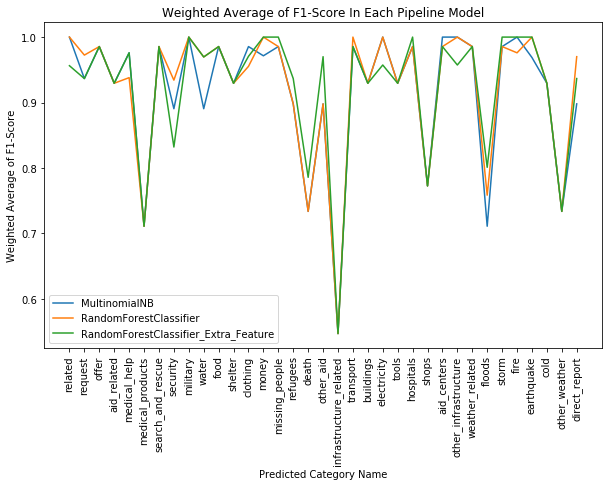

In [49]:
result_f1score_weighted_avg_comp=pd.concat([result_pipe1, result_pipe2,result_pipe3], axis=1)
result_f1score_weighted_avg_comp.columns = ["MultinomialNB","RandomForestClassifier","RandomForestClassifier_Extra_Feature"]
plt.figure(figsize=(10, 6))
plt.title('Weighted Average of F1-Score In Each Pipeline Model')
plt.xlabel('Predicted Category Name')
plt.xticks(rotation=90)
plt.ylabel('Weighted Average of F1-Score')
plt.plot(result_f1score_weighted_avg_comp )
plt.legend(result_f1score_weighted_avg_comp.columns)
plt.show()


### 9. Export your model as a pickle file

Acording to above figure,I choose to export pipeline2 , because it has better result in most categories than others.

In [53]:
with open('model.pickle', mode='wb') as fp:
    pickle.dump(cv2, fp)

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

In [65]:
#test code for a message
query = "I need food"
classification_labels = cv2.predict([query])[0]
classification_results = dict(zip(df.columns[4:], classification_labels))
classification_results

{'related': 1,
 'request': 1,
 'offer': 0,
 'aid_related': 0,
 'medical_help': 0,
 'medical_products': 0,
 'search_and_rescue': 0,
 'security': 0,
 'military': 0,
 'water': 0,
 'food': 0,
 'shelter': 0,
 'clothing': 0,
 'money': 0,
 'missing_people': 0,
 'refugees': 0,
 'death': 0,
 'other_aid': 0,
 'infrastructure_related': 0,
 'transport': 0,
 'buildings': 0,
 'electricity': 0,
 'tools': 0,
 'hospitals': 0,
 'shops': 0,
 'aid_centers': 0,
 'other_infrastructure': 0,
 'weather_related': 0,
 'floods': 0,
 'storm': 0,
 'fire': 0,
 'earthquake': 0,
 'cold': 0,
 'other_weather': 0,
 'direct_report': 0}